(218, 636, 20)


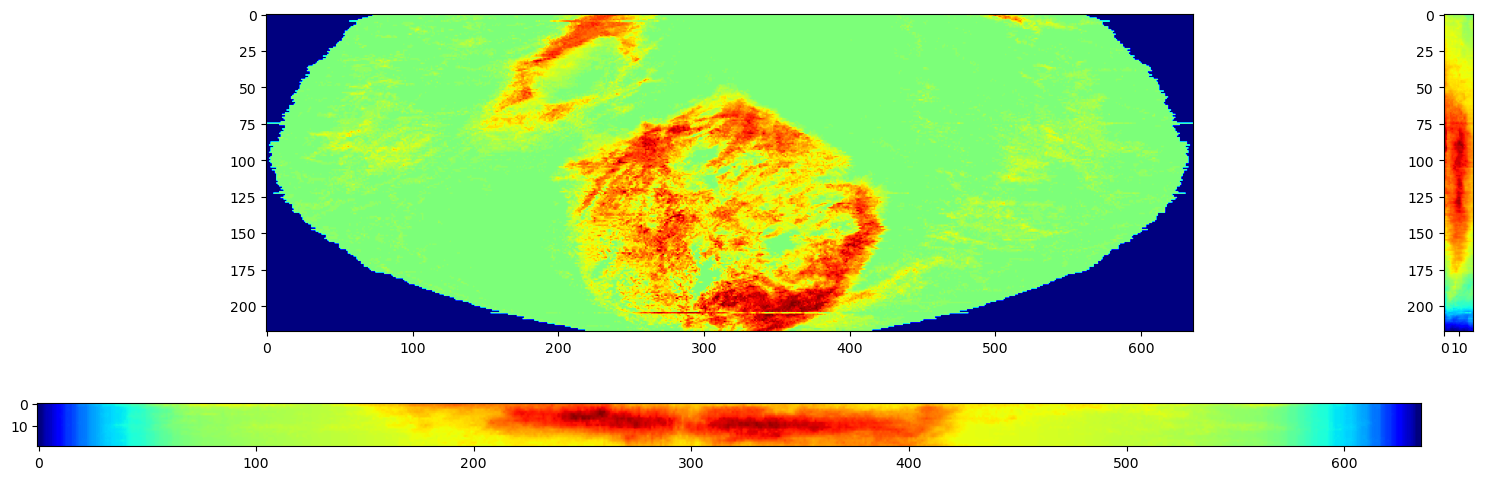

In [59]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# path = Path("/Users/arstanbek/Projects/fibrosis/BiTis/data/3D")
# path = Path("/home/arstan/Projects/Fibrosis/BiTis/data/3D")
path = Path("/Users/arstanbek/Projects/fibrosis/FibrosisSimulation/data")
hearts_list = ["Zep1", "Zep3", "Zep4",
               "Zep6", "Zep7", "Zep8",
               "Zep9", "Zep10", "Zep11"]

heart = hearts_list[0]
slab_or = np.load(path.joinpath(heart, "slab.npy")).astype(np.float32)

print(slab_or.shape)


fig, axs = plt.subplots(2, 2, figsize=(15, 5),
                        width_ratios=[1, slab_or.shape[2]/slab_or.shape[1]],
                        height_ratios=[1, slab_or.shape[0]/slab_or.shape[1]])

axs[0, 0].imshow(slab_or.sum(axis=2), cmap="jet")
axs[0, 1].imshow(slab_or.sum(axis=1), cmap="jet")
axs[1, 0].imshow(slab_or.sum(axis=0).T, cmap="jet")
axs[1, 1].axis("off")
plt.tight_layout()
plt.show()



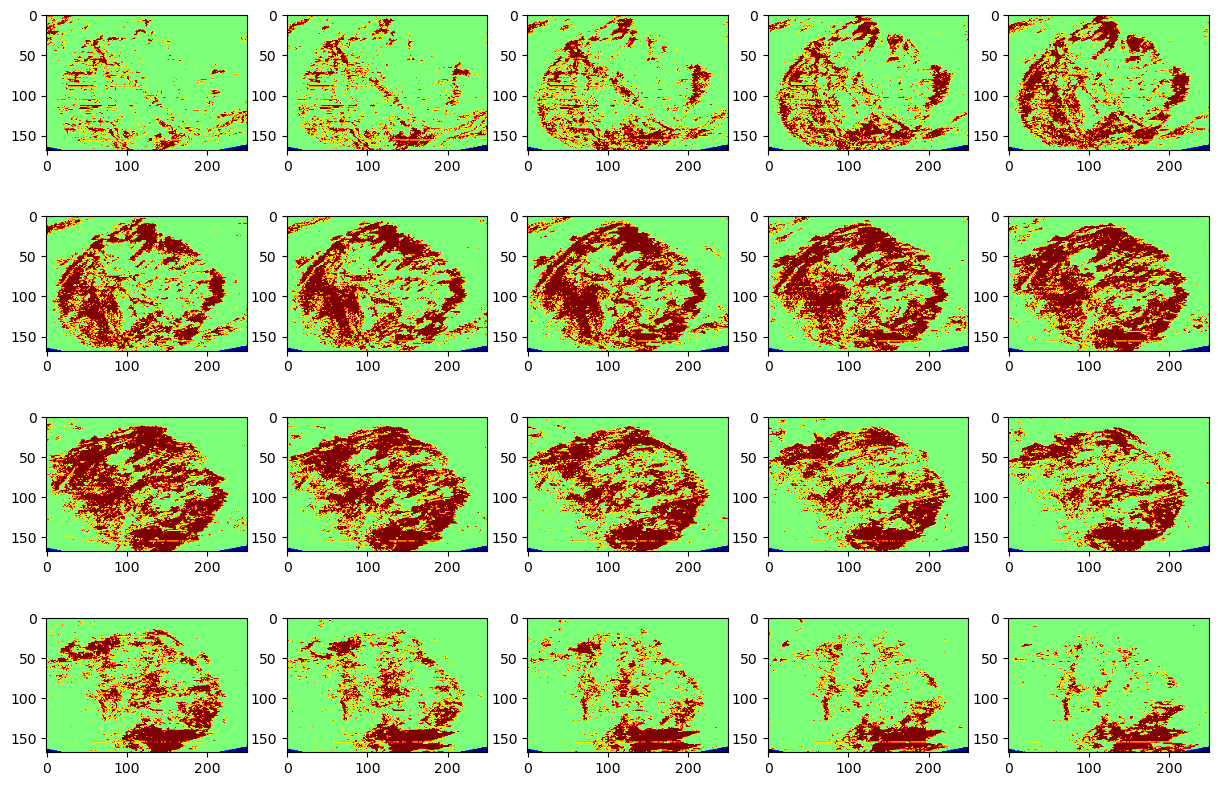

In [60]:
i_min = 50
i_max = min(300, slab_or.shape[0])
j_min = 200
j_max = min(450, slab_or.shape[1])
k_min = 0
k_max = slab_or.shape[2]

slab = slab_or[i_min:i_max, j_min:j_max, k_min:k_max]

fig, axs = plt.subplots(ncols=5, nrows=4, figsize=(15, 10))
for i in range(20):
    axs.flat[i].imshow(slab[..., i], cmap="jet")
plt.show()

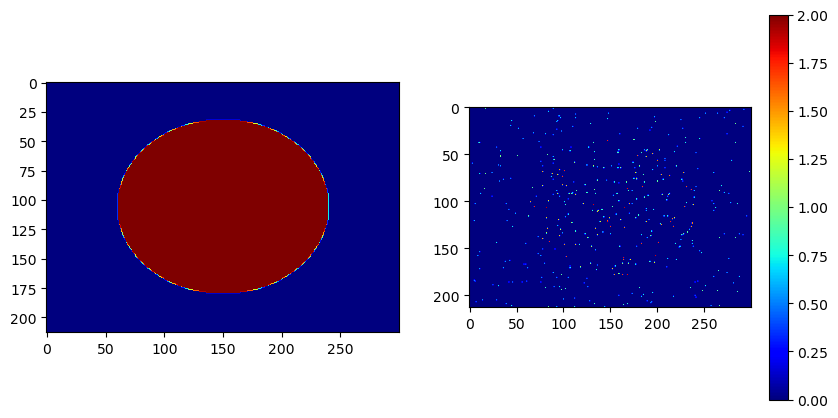

In [4]:
from skimage import draw

simulation_tex = np.zeros(slab.shape[:2], dtype=np.float32)

im = np.zeros_like(simulation_tex, dtype=bool)
# add circle to the image
x_c = simulation_tex.shape[0]//2
y_c = simulation_tex.shape[1]//2

r_x = 7 * simulation_tex.shape[0]//20
r_y = 6 * simulation_tex.shape[1]//20

rr, cc = draw.ellipse(x_c, y_c, r_x, r_y)
im[rr, cc] = 1

random_map = np.random.random(im.shape)
random_map[im == 0] = 0
random_map[(im == 1) & (np.random.random(im.shape) > 0.01)] = 0

myo_mask = (random_map > 0.7)
simulation_tex[myo_mask] = 1

fibro_mask = (random_map <= 0.7) & (random_map > 0.00)
simulation_tex[fibro_mask] = 2

mask = (im == 0) & (np.random.random(im.shape) < 0.005)
simulation_tex[mask] = 1

# %matplotlib qt
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
axs[0].imshow(im, cmap="jet")
ax_im = axs[1].imshow(simulation_tex, cmap="jet")
fig.colorbar(ax_im)
plt.show()

[(168, 250, 20), (84, 125, 10), (42, 63, 5)]


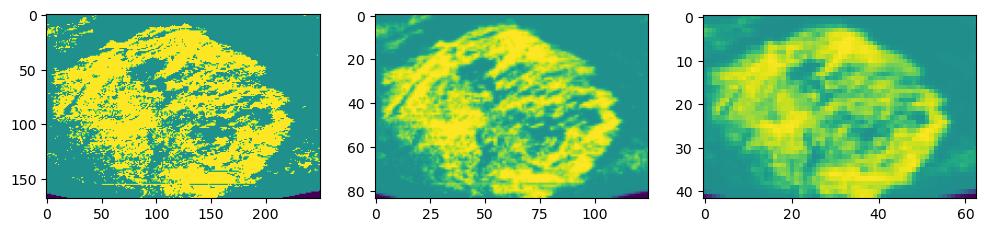

In [61]:
import numpy as np
from skimage.transform import pyramid_gaussian

# img = slab[i_min:i_max, j_min:j_max, 8]
pyramid = tuple(pyramid_gaussian(slab, max_layer=2, downscale=2,
                                 preserve_range=True))

print([p.shape for p in pyramid])

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(12, 4))
axs[0].imshow(pyramid[0][:, :, 9])
axs[1].imshow(pyramid[1][:, :, 4])
axs[2].imshow(pyramid[2][:, :, 2])
plt.show()

(42, 63, 5) (42, 63, 5)


100%|██████████| 12200/12200 [00:06<00:00, 1967.38it/s]


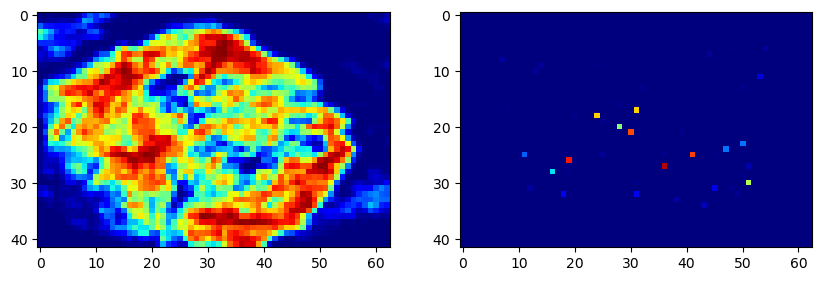

In [ ]:
import bitis as bt

# texture = slab[i_min:i_max, j_min:j_max, 8].copy()
# texture_ = texture.copy()
texture_ = pyramid[2][:, :, :].copy()
texture_[texture_ < 1] = 1
texture_ = 2 * (texture_ - 1) - 1

simulation_tex = np.zeros(texture_.shape)
simulation_tex[0, :] = -1
simulation_tex[-1, :] = -1
simulation_tex[:, 0] = -1
simulation_tex[:, -1] = -1
# simulation_tex[::3, ::3] = slab[i_min:i_max:3, j_min:j_max:3, 5].copy()

precondition_tex = simulation_tex.copy()

print(texture_.shape, simulation_tex.shape)


# simulation_tex = sim_slab.copy()
simulation = bt.AdaptiveSampling(simulation_tex,
                                 texture_,
                                 max_known_pixels=30,
                                 max_template_size=50,
                                 min_template_size=5,
                                 min_distance=0.0,
                                 min_known_pixels=1,
                                 use_tf=False)

simulated_tex = simulation.run(max_iter=None)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(texture_[..., 2], vmin=-1, vmax=1, cmap='jet')
# ax[1].imshow(precondition_tex, vmin=0, vmax=2, cmap='jet')
ax[1].imshow(simulated_tex[..., 2], vmin=-1, vmax=1, cmap='jet')
plt.show()

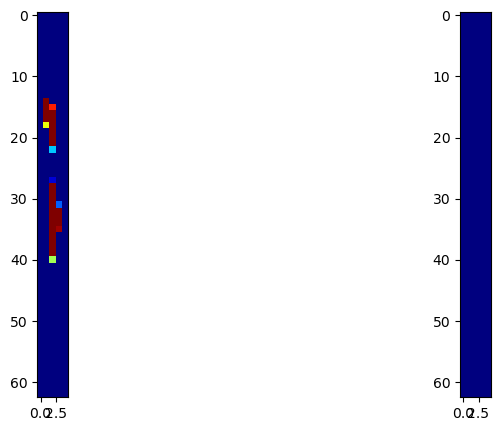

In [82]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(texture_.sum(axis=0), vmin=0, vmax=2, cmap='jet')
# ax[1].imshow(precondition_tex, vmin=0, vmax=2, cmap='jet')
ax[1].imshow(simulated_tex.sum(axis=0), vmin=0, vmax=2, cmap='jet')
plt.show()

In [1]:
fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(12, 6), sharey=True,
                        width_ratios=[0.2, 1, 1, 1, 1, 1, 1])
axs[0, 1].imshow(texture_.sum(axis=2), cmap="jet")
axs[0, 0].imshow(texture_.sum(axis=0), cmap="jet")
axs[1, 1].imshow(simulated_tex.sum(axis=2), cmap="jet")
axs[1, 0].imshow(simulated_tex.sum(axis=0), cmap="jet")
axs[0, 1].set_title("sum")

for i, idx in enumerate(np.linspace(0, simulated_tex.shape[2] - 1, 5).astype(int)):
    axs[0, i+2].imshow(texture_[:, :, idx - k_min], cmap="jet", vmin=1, vmax=2)
    axs[1, i+2].imshow(simulated_tex[:, :, idx - k_min], cmap="jet", vmin=1, vmax=2)
    axs[0, i+2].set_title(f"w={idx - k_min}")
    axs[1, i+2].set_title(f"w={idx - k_min}")
plt.tight_layout()
plt.show()
# fig.savefig("adaptive_sampling_3d.png", dpi=300, bbox_inches='tight')

NameError: name 'plt' is not defined

(165, 350) (165, 350)


100%|██████████| 56826/56826 [00:51<00:00, 1099.91it/s]


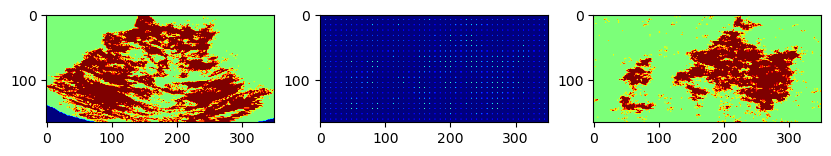

In [91]:
import bitis as bt

texture_ = slab[:, :, slab.shape[2]//2].copy()

precondition_tex = simulation_tex.copy()

print(texture_.shape, simulation_tex.shape)


# simulation_tex = sim_slab.copy()
simulation = bt.AdaptiveSampling(simulation_tex,
                                 texture_,
                                 max_known_pixels=30,
                                 max_template_size=50,
                                 min_template_size=3,
                                 min_distance=0.1,
                                 min_known_pixels=1,
                                 use_tf=True)

simulated_tex = simulation.run(max_iter=None)

fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(texture_, vmin=0, vmax=2, cmap='jet')
ax[1].imshow(precondition_tex, vmin=0, vmax=2, cmap='jet')
ax[2].imshow(simulated_tex, vmin=0, vmax=2, cmap='jet')
plt.show()

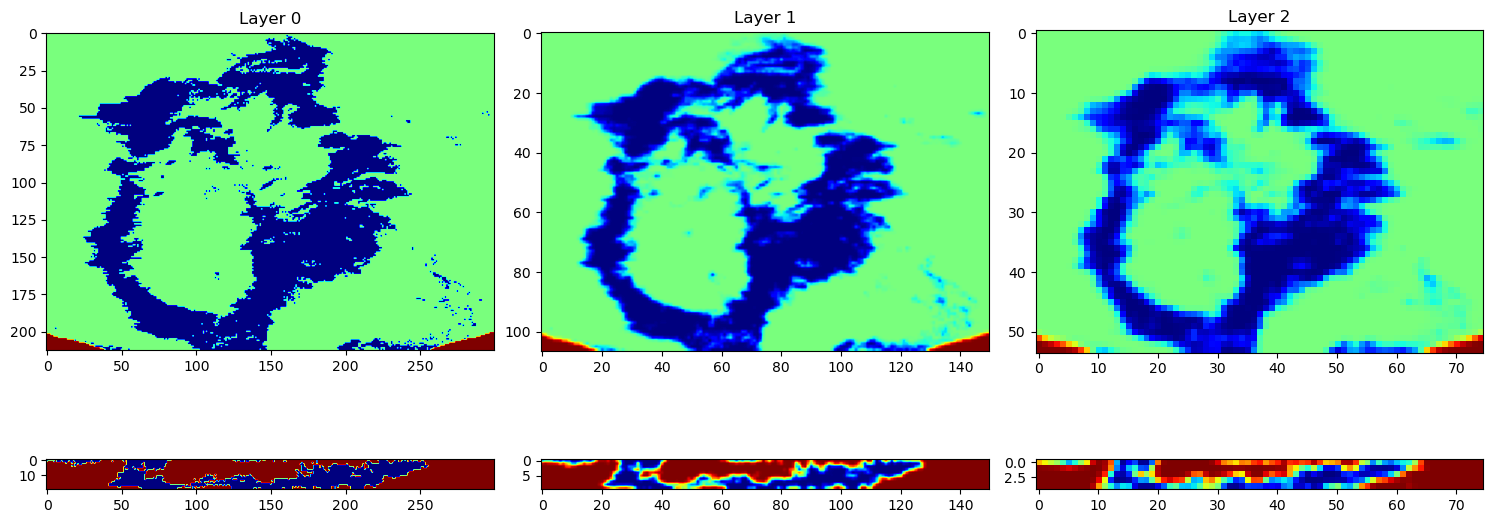

In [8]:

import numpy as np
from skimage.transform import pyramid_gaussian

img = slab[:, :, slab.shape[2]//2]
pyramid = tuple(pyramid_gaussian(slab, max_layer=2, downscale=2,
                                 preserve_range=True))

fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15, 6.8))

for i, p in enumerate(pyramid):
    axs[0, i].imshow(p[:, :, p.shape[2]//2], cmap="jet_r")
    axs[0, i].set_title(f"Layer {i}")

    axs[1, i].imshow(p[p.shape[0]//2, :, :].T , cmap="jet_r")
    axs[1, i].sharex(axs[1, i])
plt.tight_layout()
plt.show()

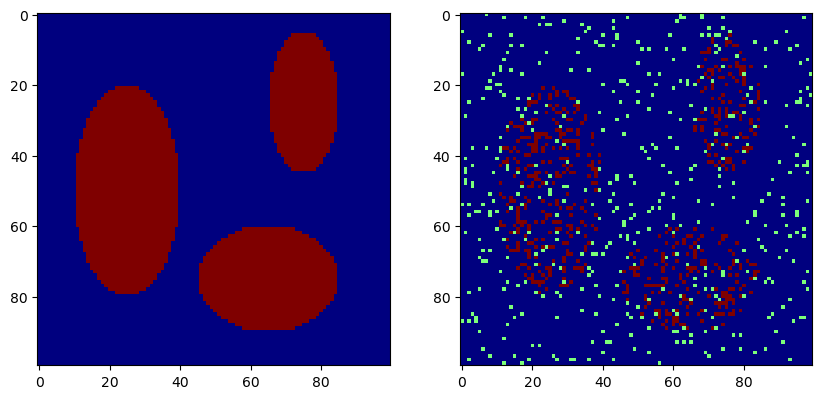

In [ ]:
sim_slab = np.zeros((100, 100, 1))

im = sim_slab[:, :, 10].copy()

# add circle to the image
from skimage import draw
rr, cc = draw.ellipse(50, 25, 30, 15)
im[rr, cc] = 1

rr, cc = draw.ellipse(75, 65, 15, 20)
im[rr, cc] = 1

rr, cc = draw.ellipse(25, 75, 20, 10)
im[rr, cc] = 1

mask = (np.random.random(im.shape) < 0.05)
sim_slab[mask, 10] = 1

mask = (im > 0) & (np.random.random(im.shape) < 0.2)
sim_slab[mask, 10] = 2

fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
axs[0].imshow(im, cmap="jet")
axs[1].imshow(sim_slab[:, :, 10], cmap="jet")
plt.show()